In [63]:
from diff_predictor import data_process, predxgboost
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 

from os import listdir, getcwd, chdir
from os.path import isfile, join
import os

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
import operator
import xgboost as xgb
import shap
from xgboost.training import CVPack
from xgboost import callback
from xgboost.core import CallbackEnv
from xgboost.core import EarlyStopException
from xgboost.core import STRING_TYPES

In [2]:
workbookDir = getcwd()

print('Current Notebook Dir: ' + workbookDir)
chdir(workbookDir) # Go to current workbook Dir"
chdir('..')        # Go up one
print(f'Using current directory for loading data: {getcwd()}')
workbookDir = getcwd()

Current Notebook Dir: /Users/nelsschimek/Documents/Nance Lab/diff_predictor/notebooks
Using current directory for loading data: /Users/nelsschimek/Documents/Nance Lab/diff_predictor


In [3]:
dataset_path = workbookDir + '/data/raw_data_age/'
filelist = [f for f in listdir(dataset_path) if isfile(join(dataset_path, f)) and 'feat' in f]
print(len(filelist))

75


RandomState(MT19937) at 0x7FFD4FB566B0

In [9]:
fstats_tot = data_process.generate_fullstats(dataset_path, filelist, ['P14','NT', 'P70'], 'age')

Adding file features_P70_40nm_s3_v3.csv size: (2322, 67)
Adding file features_P14_40nm_s3_v3.csv size: (323, 91)
Adding file features_P14_40nm_s3_v2.csv size: (243, 91)
Adding file features_P70_40nm_s3_v2.csv size: (1401, 67)
Adding file features_P14_40nm_s1_v5.csv size: (268, 91)
Adding file features_P70_40nm_s1_v5.csv size: (17, 67)
Adding file features_P14_40nm_s3_v1.csv size: (151, 91)
Adding file features_P70_40nm_s1_v4.csv size: (21, 67)
Adding file features_P70_40nm_s3_v1.csv size: (2625, 67)
Adding file features_P14_40nm_s1_v4.csv size: (140, 91)
Adding file features_P70_40nm_s3_v5.csv size: (4162, 67)
Adding file features_P14_40nm_s3_v5.csv size: (389, 91)
Adding file features_P14_40nm_s3_v4.csv size: (113, 91)
Adding file features_P70_40nm_s1_v1.csv size: (27, 67)
Adding file features_P70_40nm_s3_v4.csv size: (2909, 67)
Adding file features_P14_40nm_s1_v1.csv size: (793, 91)
Adding file features_P14_40nm_s1_v3.csv size: (519, 91)
Adding file features_P70_40nm_s1_v3.csv size: 

In [10]:
features = [
    'alpha', # Fitted anomalous diffusion alpha exponenet
    'D_fit', # Fitted anomalous diffusion coefficient
    'kurtosis', # Kurtosis of track
    'asymmetry1', # Asymmetry of trajecory (0 for circular symmetric, 1 for linear)
    'asymmetry2', # Ratio of the smaller to larger principal radius of gyration
    'asymmetry3', # An asymmetric feature that accnts for non-cylindrically symmetric pt distributions
    'AR', # Aspect ratio of long and short side of trajectory's minimum bounding rectangle
    'elongation', # Est. of amount of extension of trajectory from centroid
    'boundedness', # How much a particle with Deff is restricted by a circular confinement of radius r
    'fractal_dim', # Measure of how complicated a self similar figure is
    'trappedness', # Probability that a particle with Deff is trapped in a region
    'efficiency', # Ratio of squared net displacement to the sum of squared step lengths
    'straightness', # Ratio of net displacement to the sum of squared step lengths
    'MSD_ratio', # MSD ratio of the track
#     'frames', # Number of frames the track spans
    'Deff1', # Effective diffusion coefficient at 0.33 s
    'Deff2', # Effective diffusion coefficient at 3.3 s
    #'angle_mean', # Mean turning angle which is counterclockwise angle from one frame point to another
    #'angle_mag_mean', # Magnitude of the turning angle mean
    #'angle_var', # Variance of the turning angle
    #'dist_tot', # Total distance of the trajectory
    #'dist_net', # Net distance from first point to last point
    #'progression', # Ratio of the net distance traveled and the total distance
    'Mean alpha', 
    'Mean D_fit', 
    'Mean kurtosis', 
    'Mean asymmetry1', 
    'Mean asymmetry2',
    'Mean asymmetry3', 
    'Mean AR',
    'Mean elongation', 
    'Mean boundedness',
    'Mean fractal_dim', 
    'Mean trappedness', 
    'Mean efficiency',
    'Mean straightness', 
    'Mean MSD_ratio', 
    'Mean Deff1', 
    'Mean Deff2',
    ]

target = 'age'

In [11]:
ecm = fstats_tot[features + [target, 'Track_ID', 'X', 'Y']] #dont think i need these rn
print(ecm.shape)
ecm = ecm[~ecm[list(set(features) - set(['Deff2', 'Mean Deff2']))].isin([np.nan, np.inf, -np.inf]).any(1)]       # Removing nan and inf data points
ecm.shape

(38790, 36)


(33737, 36)

In [ ]:
ecm['alpha'].max()

## Here are the cutoffs for different motion types

### alpha > 1.25: Directed Motion
### 1.25 ≥ alpha ≥ 0.75: Normal Diffusion
### 0.75 > alpha: Anomalous Diffusion/Confined Diffusion

In [ ]:
directed = 1.25
confined = 0.75

In [ ]:
for age_target in ecm['age'].unique():
    length = len(ecm[ecm['age'] == age_target])
    print(f'num of trajs in {age_target} class is {length}')

In [ ]:
p70_ecm = ecm[ecm['age'] == 'P70']
p35_ecm = ecm[ecm['age'] == 'NT']
p28_ecm = ecm[ecm['age'] == 'P28']
p21_ecm = ecm[ecm['age'] == 'P21']
p14_ecm = ecm[ecm['age'] == 'P14']


In [ ]:
p35_ecm['age'].unique()[0]

In [ ]:
# lets look a P70 data 

age_df_list = [p70_ecm, p35_ecm, p28_ecm, p21_ecm, p14_ecm]
for df in age_df_list:
    target = df['age'].unique()[0]
    print(f'class {target}')
    directed_df = df[df['alpha'] > 1.25]
    print(f'directed diffusion %: {len(directed_df)/len(df)}')

    normal_df = df[(df['alpha'] <= 1.25) & (df['alpha'] >= 0.75)]
    print(f'normal diffusion %: {len(normal_df)/len(df)}')

    confined_df = df[df['alpha'] < 0.75]
    print(f'confined diffusion %: {len(confined_df)/len(df)}')
    print('')

In [ ]:
def ecdf(data):
    x, y = np.sort(data), np.arange(1, len(data)+1) / len(data)

In [ ]:
mx = np.array(p70_ecm['alpha'])
x = np.sort(mx)
y = np.arange(1, len(mx)+1) / len(mx)
#x, y = ecdf(mx)

In [ ]:
fig = plt.figure(figsize=(12,8))
for df in age_df_list:
    mx = np.array(df['alpha'])
    x = np.sort(mx)
    y = np.arange(1, len(mx)+1) / len(mx)
    plt.scatter(x, y, alpha=0.7, s=1, label=df['age'].unique()[0])
plt.vlines([directed], 0, 1, label='normal diffusion cutoff', linestyles='dashed')
plt.vlines(confined, 0, 1, label='confined diffusion cutoff', linestyles='dotted')
plt.xlim([0,3])
plt.legend()

In [12]:
confined_ecm = ecm[ecm['alpha'] < 0.75]
normal_ecm = ecm[(ecm['alpha'] >= 0.75) & (ecm['alpha'] <= 1.25)]
directed_ecm = ecm[ecm['alpha'] > 1.25]

directed_normal_ecm = ecm[ecm['alpha'] >= 0.75]
directed_confined_ecm = ecm[(ecm['alpha'] > 1.25) | (ecm['alpha'] < 0.75)]
normal_confined_ecm = ecm[ecm['alpha'] <= 1.25]

In [66]:
def full_preprocess(ecm, balanced=True):

    rand_state = np.random.randint(1, 2000)
    if balanced:
        bal_ecm = data_process.balance_data(ecm, target, random_state=rand_state)
        sampled_df = data_process.bin_data(bal_ecm)
        sampled_df = sampled_df.sample(0.5)
    else:
        sampled_df = data_process.bin_data(ecm)
    label_df = sampled_df['age']
    features_df = sampled_df.drop(['age', 'X', 'Y', 'binx', 'biny', 'bins', 'Track_ID'], axis=1)
    features = features_df.columns

    seed = rand_state
    np.random.seed(seed)
    train_split = 0.5
    test_split = 0.5

    le = preprocessing.LabelEncoder()
    sampled_df['encoded_target'] = le.fit_transform(sampled_df[target])

    training_bins = np.random.choice(sampled_df['bins'].unique(), int(len(sampled_df['bins'].unique())*train_split), replace=False)

    X_train = sampled_df[sampled_df['bins'].isin(training_bins)]
    X_test_val = sampled_df[~sampled_df['bins'].isin(training_bins)]
    X_val, X_test = train_test_split(X_test_val, test_size=test_split, random_state=seed)

    y_train = X_train['encoded_target']
    y_test = X_test['encoded_target']
    y_val = X_val['encoded_target']

    dtrain = xgb.DMatrix(X_train[features], label=y_train)
    dtest = xgb.DMatrix(X_test[features], label=y_test)
    dval = xgb.DMatrix(X_val[features], label=y_val)
    return dtrain, dtest, dval, y_test



In [69]:
dtrain, dtest, dval, y_test = full_preprocess(normal_ecm, balanced=False)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [70]:
param = {'max_depth': 3,
         'eta': 0.005,
         'min_child_weight': 0,
         'verbosity': 0,
         'objective': 'multi:softprob',
         'num_class': 3,
         'silent': 'True',
         'gamma': 5,
         'subsample': 0.15,
         'colsample_bytree': 0.8,
         'eval_metric': "mlogloss",
#          # GPU integration will cut time in ~half:
#          'gpu_id' : 0,
#          'tree_method': 'gpu_hist',
#          'predictor': 'gpu_predictor'
         }

In [71]:
booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=200)


[0]	train-mlogloss:1.09471	eval-mlogloss:1.09467
[1]	train-mlogloss:1.09073	eval-mlogloss:1.09076
[2]	train-mlogloss:1.08693	eval-mlogloss:1.08698
[3]	train-mlogloss:1.08329	eval-mlogloss:1.08327
[4]	train-mlogloss:1.07948	eval-mlogloss:1.07956
[5]	train-mlogloss:1.07614	eval-mlogloss:1.07633
[6]	train-mlogloss:1.07278	eval-mlogloss:1.07305
[7]	train-mlogloss:1.06921	eval-mlogloss:1.06957
[8]	train-mlogloss:1.06573	eval-mlogloss:1.06617
[9]	train-mlogloss:1.06225	eval-mlogloss:1.06273
[10]	train-mlogloss:1.05866	eval-mlogloss:1.05912
[11]	train-mlogloss:1.05491	eval-mlogloss:1.05542
[12]	train-mlogloss:1.05167	eval-mlogloss:1.05214
[13]	train-mlogloss:1.04851	eval-mlogloss:1.04909
[14]	train-mlogloss:1.04507	eval-mlogloss:1.04569
[15]	train-mlogloss:1.04162	eval-mlogloss:1.04215
[16]	train-mlogloss:1.03847	eval-mlogloss:1.03907
[17]	train-mlogloss:1.03575	eval-mlogloss:1.03629
[18]	train-mlogloss:1.03239	eval-mlogloss:1.03294
[19]	train-mlogloss:1.029	eval-mlogloss:1.02936
[20]	train-m

In [72]:
class_names = ['P14', 'P35', 'P70']
class_results = classification_report(y_test, preds, digits=4, target_names = ['P14', 'P35', 'P70'])
print(str(class_results))

              precision    recall  f1-score   support

         P14     0.8006    0.7592    0.7794       677
         P35     0.7908    0.8040    0.7974       301
         P70     0.8485    0.8877    0.8677       650

    accuracy                         0.8188      1628
   macro avg     0.8133    0.8170    0.8148      1628
weighted avg     0.8179    0.8188    0.8180      1628



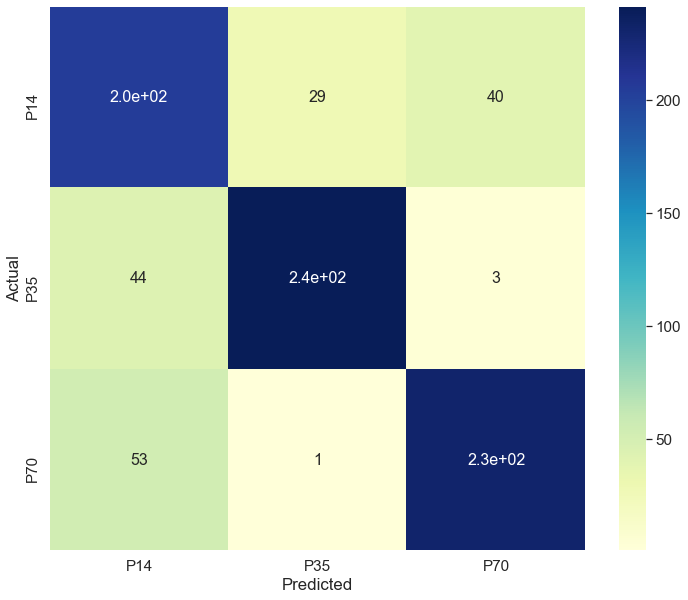

In [65]:
plt.figure(figsize=(12,10))
cm_array = confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(cm_array, index = class_names, columns = class_names)

sns.set(font_scale=1.4) # for label size
ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="YlGnBu")
ax.set(xlabel='Predicted', ylabel='Actual')

plt.show()

In [12]:
dtrain, dtest, dval = full_preprocess(confined_ecm)
booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=815, verbose=100)

Ratio before data balance (P70:P14:NT) = 8619:2029:9157
Ratio after balance (P70:P14:NT) = 2029:2029:2029


TypeError: train() got an unexpected keyword argument 'verbose'

In [ ]:
dtrain, dtest, dval = full_preprocess(directed_ecm)
booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=815)


In [ ]:
dtrain, dtest, dval = full_preprocess(ecm)
booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=815)

In [ ]:
dtrain, dtest, dval = full_preprocess(directed_confined_ecm)
booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=815)

In [ ]:
dtrain, dtest, dval = full_preprocess(directed_normal_ecm)
booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=815)

In [46]:
acc_list = []
for i in range(10):
    print(i)
    dtrain, dtest, dval = full_preprocess(normal_confined_ecm)
    booster, acc, true_label, preds = predxgboost.train(param, dtrain, dtest, dval, evals=[(dtrain, 'train'), (dval, 'eval')], num_round=200, verbose=False)
    acc_list.append(acc)

0



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Accuracy: 0.8141151579265529
1



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Accuracy: 0.8211970450776421
2



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Accuracy: 0.8254620123203286
3



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Accuracy: 0.8273111215391835
4



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Accuracy: 0.8159706287287747
5



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Accuracy: 0.8204011817757736
6



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Accuracy: 0.810136391816491
7



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Accuracy: 0.8110451848471018
8



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Accuracy: 0.83796929624563
9



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Accuracy: 0.8137740244612697


In [39]:
acc_list

[0.8121085594989561,
 0.8101851851851852,
 0.8065061258977608,
 0.7880571909167368,
 0.7980607082630692,
 0.7999148573861218,
 0.8212337389844734,
 0.8179591836734694,
 0.8014827018121911,
 0.8069267515923567]